In [15]:
from pathlib import Path
import glob

import random

import numpy as np
from numba import njit, prange

import matplotlib.pyplot as plt
from PIL import Image

In [16]:
def load_images(path: Path, thumbnail_shape: tuple) -> list[np.ndarray]:
    fnc1 = np.vectorize(lambda t: 1 if t >= 0.5 else -1)
    files = glob.glob(path.as_posix())
    images = []
    for f in files:
        img = Image.open(f).convert('L')
        img.thumbnail(thumbnail_shape, Image.Resampling.BICUBIC)
        img = np.array(img)
        img = np.apply_along_axis(fnc1, 0, img)
        images.append(img)
    return images

def split_image(img: np.ndarray, side_size: int = 2):
    parts = []

    imgw, imgh = img.shape
    xstep = imgw//side_size
    ystep = imgh//side_size

    for i in range(xstep):
        for j in range(ystep):
            parts.append(img[i*side_size:(i+1)*side_size, j*side_size:(j+1)*side_size])

    return parts

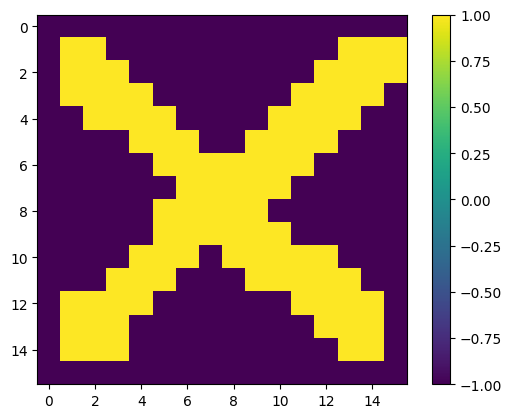

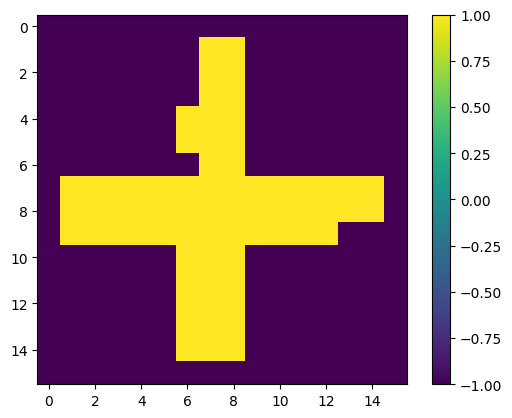

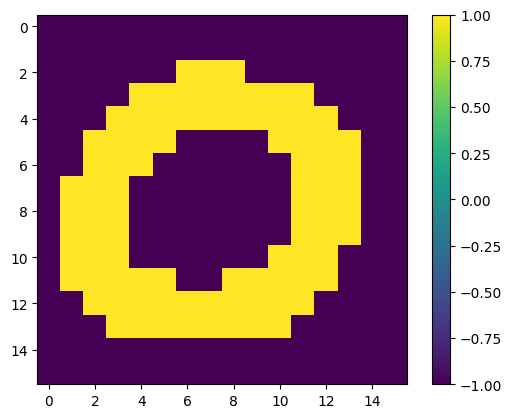

In [17]:
data = load_images(Path('..', '..', 'data', 'images', 'shapes', '*'), (16, 16))

for d in data:
    img = plt.imshow(d, cmap='viridis')
    plt.colorbar(img)
    plt.show()

In [18]:
imgs_parts = [split_image(x,4) for x in data[0:3]]

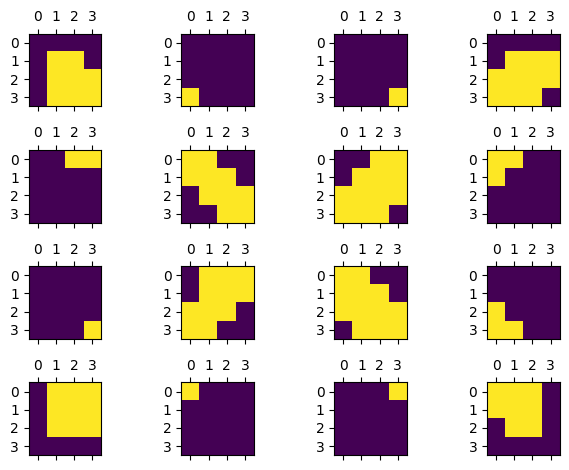

In [19]:
fig, axs = plt.subplots(nrows=4,ncols=4)

for d,ax in zip(imgs_parts[0],axs.flatten()):
    ax.matshow(d,cmap='viridis')
    
plt.tight_layout()
plt.show()

In [20]:
@njit(fastmath=True)
def fit(data: np.ndarray, n: int) -> np.ndarray:
    w = np.zeros((n, n))
    for i in prange(data.shape[0]):
        w += data[i]*data[i].reshape((n, 1))
    return w/n*(1-np.eye(n))


@njit(fastmath=True)
def reconstruct(x: np.ndarray, w: np.ndarray, n: int, niter: int) -> np.ndarray:
    for i in prange(niter):
        idx = random.randint(0, n-1)
        x[idx] = 1 if np.dot(w[idx], x) >= 0 else -1
    return x


class HopfieldNetwork:
    def __init__(self, n: int) -> None:
        self.n: int = n
        self.memshape: tuple = (n, n)
        self.w: np.ndarray = np.zeros((n, n))
        self.s = np.zeros(n)

    def learn(self, data: list[np.ndarray]):
        self.w += fit(np.array([d.flatten() for d in data]), self.n)

    def reconstruct(self, x: np.ndarray, niter: int):
        self.s = reconstruct(x.flatten(), self.w, self.n, niter)
    
    def energy(self) -> float:
        return -1/2*np.sum(np.dot(self.w,self.s))
    
    def reset(self):
        self.wnp.ndarray = np.zeros((self.n, self.n))

class HopfieldLayer:
    def __init__(self,m:int,n:int) -> None:
        self.m=m
        self.n=n
        self.models: list[HopfieldNetwork] = [HopfieldNetwork(n) for i in range(m)]
        self.s = list([None for i in range(m)])
    
    def learn(self, data: list[np.ndarray]):
        for i,d in enumerate(data):
            self.models[i].learn([d])
    
    def reconstruct(self, data: list[np.ndarray], niter: int):
        for i,d in enumerate(data):
             self.models[i].reconstruct(d,niter)
             self.s[i] = self.models[i].s
    
    def energies(self):
        return [m.energy() for m in self.models]
    
    def reset(self):
        for m in self.models:
            m.reset()

In [21]:
img_size = 16*16
m = 4*4
n = 4*4


In [22]:
layer = HopfieldLayer(m,n)

for img in imgs_parts:
    layer.learn(img)

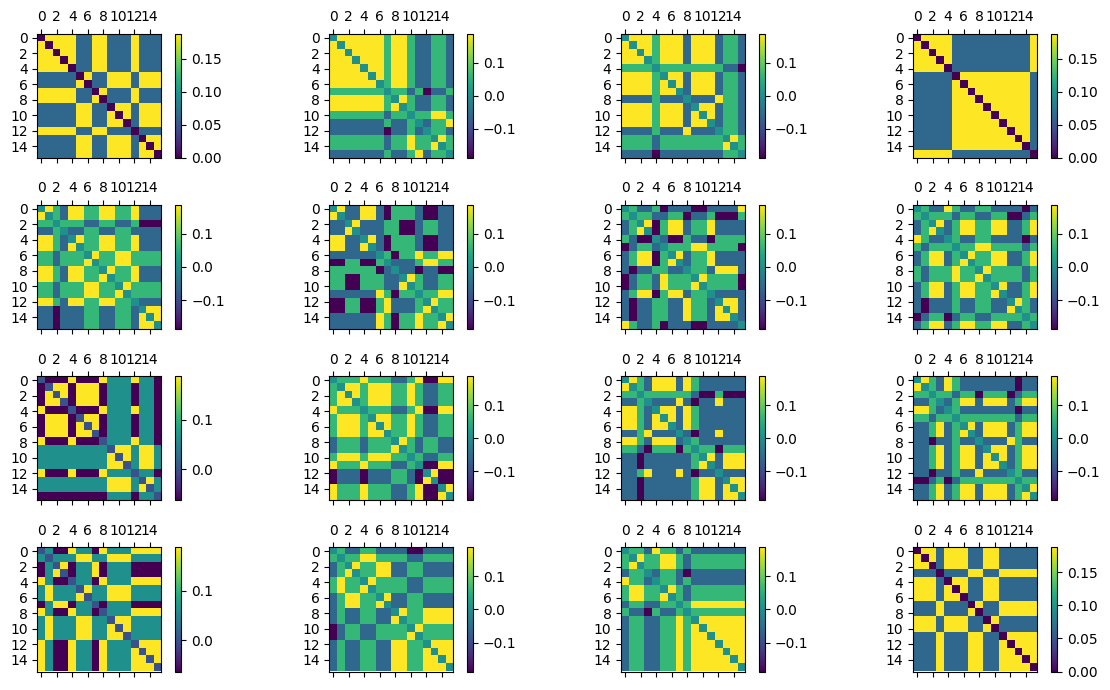

In [23]:
fig, axs = plt.subplots(nrows=4,ncols=4)
fig.set_figwidth(12)
fig.set_figheight(7)

for model,ax in zip(layer.models,axs.flatten()):
    img = ax.matshow(model.w,cmap='viridis')
    plt.colorbar(img)
    
plt.tight_layout()
plt.show()

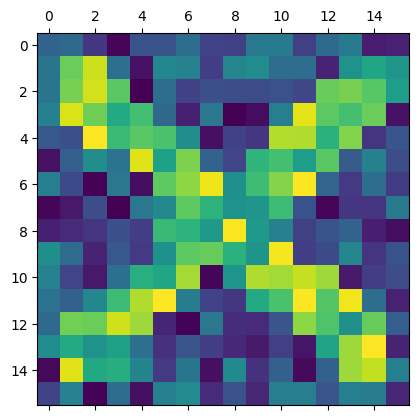

In [24]:
noise_amp = 1
x = data[0]+np.random.uniform(-noise_amp, noise_amp, (16, 16))
x_parts = split_image(x,4)

plt.matshow(x, cmap='viridis')
plt.show()

In [25]:
layer.reconstruct(x,2000)

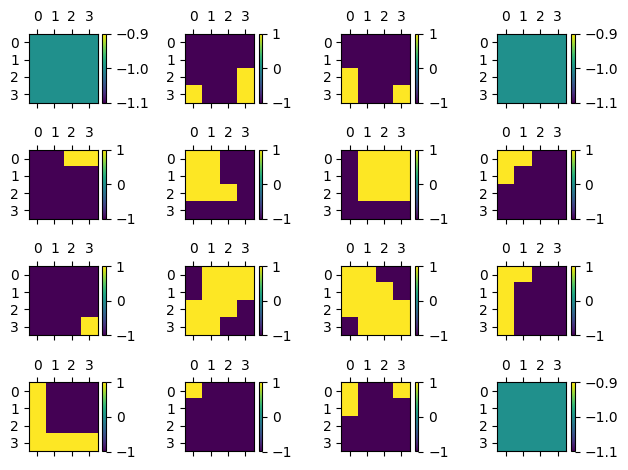

In [26]:
fig, axs = plt.subplots(nrows=4,ncols=4)

for (y,ax) in zip(layer.s, axs.flatten()):
    img = ax.matshow(y.reshape((4,4)),cmap='viridis')
    plt.colorbar(img)
    
plt.tight_layout()
plt.show()

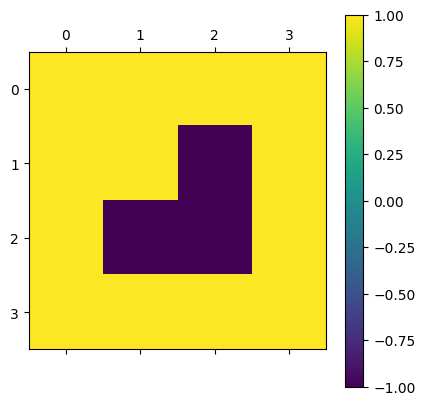

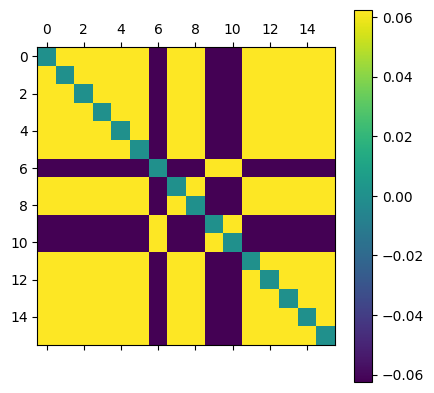

In [27]:
fnc = np.vectorize(lambda x: 1 if x >=0 else -1)

energies = layer.energies()
norm_enegries = np.apply_along_axis(fnc,0,energies)

img =  plt.matshow(norm_enegries.reshape((4,4)))
plt.colorbar(img)
plt.show()

outmodel = HopfieldNetwork(n)
outmodel.learn(np.array([norm_enegries]))

img = plt.matshow(outmodel.w)
plt.colorbar(img)

plt.show()
